# Severity of storms 

### 1.1 Business problem


Our project will focus on analyzing and predicting the severity of tornadoes across various regions in America in terms of property damage. To analyze this, we will take the last 10 years of tornado data to represent an approximate measure of it. To calculate this, we will establish a threshold for measuring the severity using the amount of property damage caused by tornadoes. We will predict the property damage of tornadoes and use a scale of low, medium, and high to represent the severity.  
In addition, we will also compare attitudes across each of the 4 seasons - summer, spring, winter, fall, and see if there are any trends present across the 10 year span that shows when tornadoes are most common and damaging. The trends will help us be more accurate in predicting the property damage caused by the tornadoes per region during different seasons/times of the year. 


### 1.2 Business understanding

### 1.3 Datasets


Our dataset details instances of severe weather across a 10 year period. The dataset shows us the date/year, the state the tornado occured in, deaths/injuries, and the property damage. We will be using this dataset to predict the property damage caused by future tornadoes in region acros the US. Bonus: We will predict deaths/injuries if we have more time. 


### 1.4 Proposed analytics solution

 How we get to the target variable -- severity index
The severity index will be calculated by… 


In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read all data into one single dataframe
df_all_data = pd.read_csv('./dataset/storm_event_details_2010.csv')

for i in range(2011,2021):
    df_temp = pd.read_csv(f'./dataset/storm_event_details_{i}.csv')
    df_all_data = df_all_data.append(df_temp, ignore_index=True)


C:\Users\doris\AppData\Local\Temp/ipykernel_16016/904002365.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_data = df_all_data.append(df_temp, ignore_index=True)
C:\Users\doris\AppData\Local\Temp/ipykernel_16016/904002365.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_data = df_all_data.append(df_temp, ignore_index=True)
C:\Users\doris\AppData\Local\Temp/ipykernel_16016/904002365.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_data = df_all_data.append(df_temp, ignore_index=True)
C:\Users\doris\AppData\Local\Temp/ipykernel_16016/904002365.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_da

In [3]:
## Remove unused columns and format continuous columns

df_hur = df_all_data[df_all_data['EVENT_TYPE']=='Tornado']
df_hur = df_hur.drop(columns=['TOR_OTHER_WFO', 'END_YEARMONTH', 'EVENT_TYPE', 'END_DATE_TIME', 'BEGIN_YEARMONTH', 
                                            'EPISODE_ID', 'EVENT_ID',
                                            'TOR_OTHER_CZ_STATE','TOR_OTHER_CZ_FIPS','TOR_OTHER_CZ_NAME','DATA_SOURCE','EPISODE_NARRATIVE',
                                            'EVENT_NARRATIVE','WFO','SOURCE','CZ_TIMEZONE','BEGIN_AZIMUTH','END_AZIMUTH','BEGIN_LAT',
                                            'END_LAT','BEGIN_LON','END_LON','STATE_FIPS','BEGIN_RANGE','END_RANGE',
                                            'BEGIN_TIME','END_TIME','BEGIN_LOCATION','END_LOCATION','FLOOD_CAUSE','MAGNITUDE_TYPE',
                                            'MAGNITUDE','CZ_FIPS','CATEGORY'])

dmg = pd.DataFrame(df_hur['DAMAGE_PROPERTY'])
for index, row in dmg.iterrows():
    if type(row['DAMAGE_PROPERTY']) != type(0.0):
        val = row['DAMAGE_PROPERTY']
        if val[-1:] == 'B':
            row['DAMAGE_PROPERTY'] = float(val[:-1])*1000000000
        elif val[-1:] == 'M':
            row['DAMAGE_PROPERTY'] = float(val[:-1])*1000000
        elif val[-1:] == 'K':
            row['DAMAGE_PROPERTY'] = float(val[:-1])*1000

dmgC = pd.DataFrame(df_hur['DAMAGE_CROPS'])
for index, row in dmgC.iterrows():
    if type(row['DAMAGE_CROPS']) != type(0.0):
        val = row['DAMAGE_CROPS']
        if val[-1:] == 'B':
            row['DAMAGE_CROPS'] = float(val[:-1])*1000000000
        elif val[-1:] == 'M':
            row['DAMAGE_CROPS'] = float(val[:-1])*1000000
        elif val[-1:] == 'K':
            row['DAMAGE_CROPS'] = float(val[:-1])*1000

df_hur['DAMAGE_PROPERTY'] = dmg
df_hur['DAMAGE_CROPS'] = dmgC

df_dqr = df_hur.copy()
cols = ['INJURIES_INDIRECT', 'INJURIES_DIRECT', 'DEATHS_INDIRECT', 'DEATHS_DIRECT']
df_hur = df_hur.assign(HARM_TOTAL=df_hur[cols].sum(1)).drop(cols,1)
df_hur['TOR_AREA'] = df_hur['TOR_LENGTH']*df_hur['TOR_WIDTH']
df_hur = df_hur.drop(columns=['TOR_LENGTH', 'TOR_WIDTH'])

df_hur = df_hur.dropna()

df_dqr.info()

C:\Users\doris\AppData\Local\Temp/ipykernel_16016/491463145.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_hur = df_hur.assign(HARM_TOTAL=df_hur[cols].sum(1)).drop(cols,1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14988 entries, 75 to 688592
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BEGIN_DAY          14988 non-null  int64  
 1   END_DAY            14988 non-null  int64  
 2   STATE              14988 non-null  object 
 3   YEAR               14988 non-null  int64  
 4   MONTH_NAME         14988 non-null  object 
 5   CZ_TYPE            14988 non-null  object 
 6   CZ_NAME            14988 non-null  object 
 7   BEGIN_DATE_TIME    14988 non-null  object 
 8   INJURIES_DIRECT    14988 non-null  int64  
 9   INJURIES_INDIRECT  14988 non-null  int64  
 10  DEATHS_DIRECT      14988 non-null  int64  
 11  DEATHS_INDIRECT    14988 non-null  int64  
 12  DAMAGE_PROPERTY    12945 non-null  object 
 13  DAMAGE_CROPS       12463 non-null  object 
 14  TOR_F_SCALE        14988 non-null  object 
 15  TOR_LENGTH         14988 non-null  float64
 16  TOR_WIDTH          1

<AxesSubplot: xlabel='TOR_AREA', ylabel='DAMAGE_PROPERTY'>

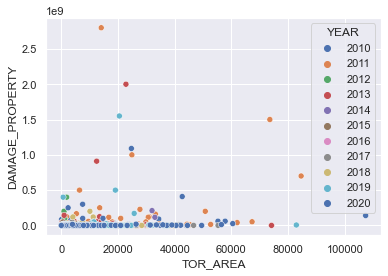

In [4]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.scatterplot(data=df_hur, x='TOR_AREA', y='DAMAGE_PROPERTY', hue='YEAR', palette='deep')

In [5]:
## Format DAMAGE_PROPERTY column to be float instead of object

# dmg = pd.DataFrame(df_hur['DAMAGE_PROPERTY'])

# print(dmg)
# for index, row in dmg.iterrows():
#     val = row['DAMAGE_PROPERTY']
#     if val[-1:] == 'B':
#         row['DAMAGE_PROPERTY'] = float(val[:-1])*1000000000
#     elif val[-1:] == 'M':
#         row['DAMAGE_PROPERTY'] = float(val[:-1])*1000000
#     elif val[-1:] == 'K':
#         row['DAMAGE_PROPERTY'] = float(val[:-1])*1000

# df_hur['DAMAGE_PROPERTY'] = dmg

In [6]:
## Sort by priority variable and find data split percentages

df_hur = df_hur.sort_values('DAMAGE_PROPERTY', ascending=False)
df_hur.info()
df_hur = df_hur.loc[df_hur['TOR_F_SCALE']!='EFU']
print(df_hur['TOR_F_SCALE'].value_counts()/len(df_hur) * 100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12091 entries, 100619 to 688560
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BEGIN_DAY        12091 non-null  int64  
 1   END_DAY          12091 non-null  int64  
 2   STATE            12091 non-null  object 
 3   YEAR             12091 non-null  int64  
 4   MONTH_NAME       12091 non-null  object 
 5   CZ_TYPE          12091 non-null  object 
 6   CZ_NAME          12091 non-null  object 
 7   BEGIN_DATE_TIME  12091 non-null  object 
 8   DAMAGE_PROPERTY  12091 non-null  object 
 9   DAMAGE_CROPS     12091 non-null  object 
 10  TOR_F_SCALE      12091 non-null  object 
 11  HARM_TOTAL       12091 non-null  int64  
 12  TOR_AREA         12091 non-null  float64
dtypes: float64(1), int64(4), object(8)
memory usage: 1.3+ MB
EF0    51.846797
EF1    35.212829
EF2     9.750064
EF3     2.473770
EF4     0.622707
EF5     0.093833
Name: TOR_F_SCALE, dtype: float

In [7]:
df_hur['MONTH_NAME'].value_counts()/len(df_hur) * 100

April        21.572976
May          20.992920
June         12.360317
July          7.182462
March         6.508573
August        6.099121
October       4.870767
November      4.572208
January       4.248059
February      4.128636
December      3.770366
September     3.693594
Name: MONTH_NAME, dtype: float64

In [8]:
## Split data into strata and sample proportinally (stratified sampling)

sampled_df = df_hur.groupby('TOR_F_SCALE', group_keys=False).apply(lambda x: x.sample(frac=0.1))
sampled_df

,BEGIN_DAY,END_DAY,STATE,YEAR,MONTH_NAME,CZ_TYPE,CZ_NAME,BEGIN_DATE_TIME,DAMAGE_PROPERTY,DAMAGE_CROPS,TOR_F_SCALE,HARM_TOTAL,TOR_AREA
254497,17,17,MICHIGAN,2013,November,C,OTSEGO,17-NOV-13 16:27:00,11000.0,0.0,EF0,0,43.50
333997,8,8,KANSAS,2015,April,C,COMANCHE,08-APR-15 17:24:00,0.0,0.0,EF0,0,143.25
95476,2,2,WYOMING,2011,July,C,GOSHEN,02-JUL-11 18:37:00,0.0,0.0,EF0,0,0.40
52433,8,8,KANSAS,2010,June,C,FRANKLIN,08-JUN-10 16:55:00,0.0,0.0,EF0,0,0.50
30943,22,22,COLORADO,2010,April,C,ADAMS,22-APR-10 14:38:00,0.0,0.0,EF0,0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378427,23,23,MISSISSIPPI,2015,December,C,MARSHALL,23-DEC-15 16:12:00,5000000.0,0.0,EF4,32,32682.00
331518,9,9,ILLINOIS,2015,April,C,OGLE,09-APR-15 17:43:00,10000000.0,0.0,EF4,0,14658.00
574464,3,3,ALABAMA,2019,March,C,LEE,03-MAR-19 14:03:00,0.0,0.0,EF4,113,37680.00
168814,29,29,ILLINOIS,2012,February,C,SALINE,29-FEB-12 04:51:00,2000000.0,0.0,EF4,103,5177.25


In [9]:
## DQR for categorical variables

cat_cols = ['STATE', 'YEAR', 'MONTH_NAME', 'TOR_F_SCALE', 'BEGIN_DAY', 'END_DAY', 'CZ_NAME']
cat_df = df_dqr[cat_cols]
cat_df

dqr_cat = pd.DataFrame(columns=['Feature', 'Description', 'Count', '% Missing', 'Cardinality','Mode',
'Mode Frequency', 'Mode %', '2nd Mode', '2nd Mode Frequency', '2nd Mode %'])

descs = ['State where tornado touched down', 'Year of occurence', 'Month of occurence', 'Fujita Scale for intensity of tornado', 
'Day of the month tornado touched down', 'Day of the month tornado disappated','Name of county of occurence']

dqr_cat['Feature'] = cat_cols

for index, row in dqr_cat.iterrows():
    row['Description'] = descs[index]
    row['Count'] = df_dqr[row['Feature']].count()
    row['Cardinality'] = len(df_dqr[row['Feature']].unique())
    row['Mode'] = df_dqr[row['Feature']].mode()[0]
    if row['Feature'] == 'TOR_F_SCALE':
        row['% Missing'] = round((len(df_dqr[df_dqr[row['Feature']]=='EFU'])/row['Count'])*100, 2)    
    row['% Missing'] = round((len(df_dqr[df_dqr[row['Feature']]==None])/row['Count'])*100, 2)
    row['Mode Frequency'] = len(df_dqr[df_dqr[row['Feature']]==row['Mode']])
    row['Mode %'] = round(row['Mode Frequency']/row['Count']*100, 2)
    mode_df = df_dqr[df_dqr[row['Feature']]!=row['Mode']]
    row['2nd Mode'] = mode_df[row['Feature']].mode()[0]
    row['2nd Mode Frequency'] = len(mode_df[mode_df[row['Feature']]==row['2nd Mode']])
    row['2nd Mode %'] = round(row['2nd Mode Frequency']/row['Count']*100, 2)

dqr_cat

,Feature,Description,Count,% Missing,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,STATE,State where tornado touched down,14988,0.0,52,TEXAS,1359,9.07,OKLAHOMA,1012,6.75
1,YEAR,Year of occurence,14988,0.0,11,2011,2074,13.84,2019,1732,11.56
2,MONTH_NAME,Month of occurence,14988,0.0,12,May,3181,21.22,April,3122,20.83
3,TOR_F_SCALE,Fujita Scale for intensity of tornado,14988,0.0,7,EF0,7379,49.23,EF1,5263,35.11
4,BEGIN_DAY,Day of the month tornado touched down,14988,0.0,31,27,830,5.54,19,663,4.42
5,END_DAY,Day of the month tornado disappated,14988,0.0,31,27,828,5.52,19,662,4.42
6,CZ_NAME,Name of county of occurence,14988,0.0,1529,WASHINGTON,194,1.29,JACKSON,133,0.89


In [10]:
dqr_cont = pd.DataFrame(columns=['Feature', 'Description','Count','% Missing', 'Cardinality','Min','Q1','Median','Q3','Max','Mean','STD'])

cont_cols = ['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'TOR_WIDTH', 'TOR_LENGTH', 'INJURIES_INDIRECT', 'INJURIES_DIRECT', 'DEATHS_INDIRECT', 'DEATHS_DIRECT']
dqr_cont['Feature'] = cont_cols
total_count = np.size(df_dqr)
descs = ['Property damage caused in dollars', 'Crops damaged in dollars', 'Width of the tornado', 'Length of tornado', 
'Injuried caused inderectly from hurricane (traffic, crime, etc.)', 'Injuries directly caused by tornado (debris, wind, etc.)', 
'Deaths caused indirectly by tornado', 'Deaths caused directly by tornado']

for index, row in dqr_cont.iterrows():
    row['Description'] = descs[index]
    row['Count'] = df_dqr[row['Feature']].count()
    if row['Feature'] == 'DAMAGE_PROPERTY':
        row['% Missing'] = round(row['Count']/total_count * 100, 2)
    else:
        row['% Missing'] = round((len(df_dqr[df_dqr[row['Feature']]==None])/row['Count'])*100, 2)
    row['Cardinality'] = len(df_dqr[row['Feature']].unique())
    row['Min'] = df_dqr[row['Feature']].min()
    row['Max'] = df_dqr[row['Feature']].max()
    row['Q1'] = df_dqr[row['Feature']].quantile(0.25)
    row['Q3'] = df_dqr[row['Feature']].quantile(0.75)
    row['Median'] = df_dqr[row['Feature']].median()
    row['Mean'] = df_dqr[row['Feature']].sum()/row['Count']
    row['STD'] = df_dqr[row['Feature']].std()

dqr_cont

,Feature,Description,Count,% Missing,Cardinality,Min,Q1,Median,Q3,Max,Mean,STD
0,DAMAGE_PROPERTY,Property damage caused in dollars,12945,5.08,396,0.0,0.0,10000.0,80000.0,2800000000.0,1861676.964079,41350119.300074
1,DAMAGE_CROPS,Crops damaged in dollars,12463,0.0,77,0.0,0.0,0.0,0.0,7500000.0,10989.529006,159017.852828
2,TOR_WIDTH,Width of the tornado,14988,0.0,325,1.0,50.0,100.0,200.0,4576.0,193.541461,297.314431
3,TOR_LENGTH,Length of tornado,14988,0.0,1602,0.01,0.47,1.57,4.08,41.88,3.111213,4.234525
4,INJURIES_INDIRECT,Injuried caused inderectly from hurricane (tra...,14988,0.0,9,0,0.0,0.0,0.0,90,0.015479,0.834884
5,INJURIES_DIRECT,"Injuries directly caused by tornado (debris, w...",14988,0.0,71,0,0.0,0.0,0.0,1150,0.776421,14.484436
6,DEATHS_INDIRECT,Deaths caused indirectly by tornado,14988,0.0,4,0,0.0,0.0,0.0,8,0.001801,0.07704
7,DEATHS_DIRECT,Deaths caused directly by tornado,14988,0.0,24,0,0.0,0.0,0.0,158,0.065786,1.495241


BINNING AND TRANSFORMATIONS

In [42]:
#Code to bin will go here
#Will be binning the damage property into low, medium, high etc.
#To determine the cuts, visualize the data based on damage property to magnitude
#Maybe try finding the hgihest value of damage property per tornado category and bin based on these numbers
#Low = EF0 EF1
#Medium = EF2, EF3
#High = EF4, EF5

# df_mag = df_dqr[df_dqr['TOR_F_SCALE']=='EF0']
# ef0_max = df_mag['DAMAGE_PROPERTY'].max()
# #df_mag
# print('EF0 Max: ', ef0_max)

magnitudes = ['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']
bins = [df_dqr['DAMAGE_PROPERTY'].min()]
for x in magnitudes:
    df_mag = df_dqr[df_dqr['TOR_F_SCALE']==x]
    ef_max = df_mag['DAMAGE_PROPERTY'].max()
    if(x == 'EF1' or x == 'EF3' or x == 'EF5'):
        bins.append(ef_max)
    print(x, ' Max: ', ef_max)

print(bins)
pd.cut(df_hur['DAMAGE_PROPERTY'], bins, labels=["Low", "Medium", "High"])

EF0  Max:  nan
EF1  Max:  Low
EF2  Max:  Low
EF3  Max:  Medium
EF4  Max:  Medium
EF5  Max:  High
['Low', 'Low', 'Medium', 'High']


ValueError: could not convert string to float: 'Low'